<a href="https://colab.research.google.com/github/allpirez/Modelo_RNC_IMP/blob/main/Modelo_RNC_IMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Creación de un modelo de RNC con Pytorch.

Se conecta al directorio y se instalan las bibliotecas necesarias.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd "/content/gdrive/MyDrive/SaltSeg_Unet_pytorch_Segmentation_models/"

/content/gdrive/MyDrive/SaltSeg_Unet_pytorch_Segmentation_models


In [3]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

Found existing installation: opencv-python-headless 4.5.2.52
Uninstalling opencv-python-headless-4.5.2.52:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.2.52.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-8daa01ff.so.58.109.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-06a336f2.so.58.61.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-01d48d95.so.56.60.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-098682aa.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libpng15-c2ffaf3d.so.15.13.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libssl-f3db6a3b.so.1.1
    /usr/local/lib/python3.7/dist-package

In [4]:
# última versión de Albumentations
!pip install -U git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-eq78wr3h
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-eq78wr3h


In [5]:
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

Se importan las bibliotecas y modulos necesarios

In [6]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Se define la ubicación de los conjuntos de datos de entrenamiento, de validación y de prueba


In [7]:
train_img_dir = "data/train_images/"
train_mask_dir = "data/train_masks/"

val_img_dir = "data/val_images/"
val_mask_dir = "data/val_masks/"

test_img_dir = "data/test_images/"
test_mask_dir = "data/test_masks/"

Creamos funciones para enlistar en un DataFrame las imágenes y vemos su longitud

In [9]:
def crear_train_df():
    nombre = []
    for dirnom, _, filenames in os.walk(train_img_dir):
        for filename in filenames:
            nombre.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': nombre}, index = np.arange(0, len(nombre)))

df = crear_train_df()
print('Total de imagenes de entrenamiento: ', len(df))

Total de imagenes de entrenamiento:  3550


In [10]:
def crear_valid_df():
    nombre = []
    for dirnom, _, filenames in os.walk(val_img_dir):
        for filename in filenames:
            nombre.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': nombre}, index = np.arange(0, len(nombre)))

df_val = crear_valid_df()
print('Total de imagenes de validación: ', len(df_val))

Total de imagenes de validación:  400


In [11]:
def crear_test_df():
    nombre = []
    for dirname, _, filenames in os.walk(test_img_dir):
        for filename in filenames:
            nombre.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': nombre}, index = np.arange(0, len(nombre)))

df_test = crear_test_df()
print('Total de imagenes de prueba: ', len(df_test))

Total de imagenes de prueba:  50


Se visualiza un ejemplo de un par de conjunto de datos de entrenamiento

Tamaño de imagen (101, 101, 3)
Tamaño de máscara (101, 101)


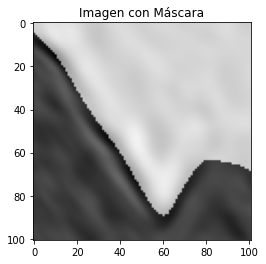

In [12]:
img = Image.open(train_img_dir + df['id'][1008] + '.png')
mask = Image.open(train_mask_dir + df['id'][1008] + '.png')
print('Tamaño de imagen', np.asarray(img).shape)
print('Tamaño de máscara', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Imagen con Máscara')
plt.show()

##Preparación de datos

In [13]:
Yclass Conjunto_de_Datos(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("L"), dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        image[image == 255.0] = 1.0
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

Se definen las transformaciones a realizar a las imagenes con la biblioteca Albumentations

In [14]:
mean =[0.485]
std= [0.229]

t_train = A.Compose([A.Resize(128, 128, interpolation=cv2.INTER_NEAREST), 
                     A.HorizontalFlip(p=1.0),
                      A.Blur(blur_limit=7, always_apply=False, p=0.5),
                      A.Normalize(
                          mean=mean,
                          std=std,
                          max_pixel_value=255.0,
                      ),
                      ToTensorV2()])


                    
t_val = A.Compose([A.Resize(128, 128, interpolation=cv2.INTER_NEAREST), 
                      A.Normalize(
                          mean=mean,
                          std=std,
                          max_pixel_value=255.0,
                      ),
                      ToTensorV2()])



Creamos los conjuntos de datos y los DataLoader, con el número de imagenes por lote para el entrenamiento

In [15]:
train_set = Conjunto_de_Datos(train_img_dir, train_mask_dir, t_train)
val_set = Conjunto_de_Datos(val_img_dir, val_mask_dir, t_val)
test_set = Conjunto_de_Datos(test_img_dir, test_mask_dir, t_val)

batch_size= 32 
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False) 
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False) 

In [16]:
train_features, train_labels = next(iter(train_loader))
print(f"Dimensiones del lote de características: {train_features.size()}")
print(f"Dimensiones del lote de etiquetas: {train_labels.size()}")

Dimensiones del lote de características: torch.Size([32, 1, 128, 128])
Dimensiones del lote de etiquetas: torch.Size([32, 128, 128])


## Modelo

Con la biblioteca segmentation-models-pytorch creamos el modelo de RNC. Se determinan los parámetros deseados

In [17]:
params_aux=dict(
    pooling='max',             # agrupamiento máximo
    dropout=0.5,               # proporción de abandono
    activation='sigmoid',      # función de activación
    classes=1,                 # número de etiquetas de salida (1: sal)
)

modelo = smp.Unet('resnet34', encoder_weights='imagenet', encoder_depth=4, decoder_channels=[512, 256, 128, 64], aux_params=params_aux, in_channels=1)

Visualizamos el modelo

In [18]:
modelo

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Entrenamiento

Definimos los hiperparámetros deseados y se definen funciones para realizar el entrenamiento, guardar los checkpoints y evaluar el modelo durante el entrenamiento

In [19]:
Tasa_de_aprendizaje = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
tamaño_de_lote = 16
num_epocas = 10
num_workers = 2
img_altura = 128  
img_ancho = 128  
pin_memory = True
load_model = False

In [20]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            
            a , b =model(x)

            preds = torch.sigmoid(a)
            
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8)
            
            writer.add_scalar("Dice_Score/val", dice_score/len(loader), epoch)
            writer.add_scalar("Acc/val", num_correct/num_pixels*100, epoch)
            
    print(
        f"Se obtuvo {num_correct}/{num_pixels} con precisión {num_correct/num_pixels*100:.2f}"
    )
    print(f"Coeficiente Dice: {dice_score/len(loader)}") 

    model.train()
    return dice_score


def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        model = model.to(device)
        targets = targets.float().unsqueeze(1).to(device=device)

        running_loss=0
        loss_values =[]

        # hacia adelante
        with torch.cuda.amp.autocast():
            predictions, _ = model(data)

            loss = loss_fn(predictions, targets)
            writer.add_scalar("Loss/train", loss, epoch)

        # hacia atrás
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        loss_values.append(running_loss/len(train_set))
            
        

        

        # se actualiza el loop tqdm
        loop.set_postfix(loss=loss.item())
    return loss_values

        

Se define la función costo, el optimizador y el escalador

In [21]:
writer = SummaryWriter()

costo = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelo.parameters(), lr=Tasa_de_aprendizaje)


if load_model:
  load_checkpoint(torch.load("my_checkpoint_1canal.pth.tar"), modelo)

scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epocas):
  running_loss=0
  train_fn(train_loader, modelo, optimizer, costo, scaler)
  

  # salva el modelo
  checkpoint = {
      "state_dict": modelo.state_dict(),
      "optimizer":optimizer.state_dict(),
      }
      
  save_checkpoint(checkpoint)

  # revisar precisión
  check_accuracy(val_loader, modelo, device=device)
      
writer.flush()
writer.close()

  0%|          | 0/111 [00:00<?, ?it/s]

=> Saving checkpoint
Se obtuvo 6150699/6553600 con precisión 93.85
Coeficiente Dice: 0.8703267574310303


  0%|          | 0/111 [00:00<?, ?it/s]

=> Saving checkpoint
Se obtuvo 6171002/6553600 con precisión 94.16
Coeficiente Dice: 0.8770595192909241


  0%|          | 0/111 [00:00<?, ?it/s]

=> Saving checkpoint
Se obtuvo 6122616/6553600 con precisión 93.42
Coeficiente Dice: 0.8625858426094055


  0%|          | 0/111 [00:00<?, ?it/s]

=> Saving checkpoint
Se obtuvo 6193027/6553600 con precisión 94.50
Coeficiente Dice: 0.8839317560195923


  0%|          | 0/111 [00:00<?, ?it/s]

=> Saving checkpoint
Se obtuvo 6208215/6553600 con precisión 94.73
Coeficiente Dice: 0.8917669653892517


  0%|          | 0/111 [00:00<?, ?it/s]

=> Saving checkpoint
Se obtuvo 6191610/6553600 con precisión 94.48
Coeficiente Dice: 0.8847718834877014


  0%|          | 0/111 [00:00<?, ?it/s]

=> Saving checkpoint
Se obtuvo 6214522/6553600 con precisión 94.83
Coeficiente Dice: 0.8919788002967834


  0%|          | 0/111 [00:00<?, ?it/s]

=> Saving checkpoint
Se obtuvo 6195720/6553600 con precisión 94.54
Coeficiente Dice: 0.8868750929832458


  0%|          | 0/111 [00:00<?, ?it/s]

=> Saving checkpoint
Se obtuvo 6246909/6553600 con precisión 95.32
Coeficiente Dice: 0.9002410769462585


  0%|          | 0/111 [00:00<?, ?it/s]

=> Saving checkpoint
Se obtuvo 6236627/6553600 con precisión 95.16
Coeficiente Dice: 0.9026671051979065


##Evaluación

Evaluamos la precisión con el conjunto de datos de prueba

In [22]:
check_accuracy(test_loader, modelo, device=device)

Se obtuvo 794225/819200 con precisión 96.95
Coeficiente Dice: 0.9518157243728638


tensor(1.9036, device='cuda:0')